### Problem Statement
Signature is one of the most popular and commonly accepted biometric hallmarks that has been used since the ancient times for verifying different entities related to human beings, viz. documents, forms, bank checks, individuals, etc. Therefore, signature verification is a critical task and many efforts have been made to remove the uncertainty involved in the manual authentication procedure, which makes signature verification an important research line in the field of machine learning and pattern recognition. 


In this notebook, we model a writer independent **signature verification** task with a **convolutional Siamese network**.

### About the Dataset:


The BHSig260 signature dataset contains the signatures of 260 persons, among them 100 were signed in Bengali and 160 are signed in Hindi. 

For each of the signers, 24 genuine and 30 forged signatures are available. This results in 100 × 24 = 2, 400 genuine and 100 × 30 = 3, 000 forged signatures in Bengali, and 160 × 24 = 3, 840 genuine and 160×30 = 4, 800 forged signatures in Hindi.

In this task we are considering only Hindi singatures for easeness. 


**Paper Link:**  https://arxiv.org/pdf/1707.02131.pdf

In [1]:
import tensorflow as tf
print (tf.__version__)

2.4.1


In [2]:
tf.keras.backend.clear_session()

In [3]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
project_path = '/content/drive/My Drive/PGP-AIML/Advanced Computer Vision/20201205/Signature recognition/'

In [6]:
from zipfile import ZipFile

with ZipFile(project_path+'BHSig260.zip', 'r') as z:
  z.extractall()

### Considering only Hindi signatures from the dataset.

In [7]:
path = "./BHSig260/Hindi/"

In [8]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [9]:
dir_list

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',


In [10]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory) 
    #This returns all the images available under a particular directory, say 160, from the above list of directories.

    images.sort()
    images = [path+directory+'/'+x for x in images] 
    #Appends the complete path, like ./BHSig260/Hindi/160/H-S-160-F-01.tif to the image name. 
    #Here './BHSig260/Hindi/160/' is the path & 'H-S-160-F-01.tif' is the name

    forg_groups.append(images[:30]) # First 30 signatures in each folder are forged. Example: './BHSig260/Hindi/160/H-S-160-F-01.tif'
    orig_groups.append(images[30:]) # Next 24 signatures are genuine. Example: './BHSig260/Hindi/160/H-S-160-F-35.tif'

##### Both the groups contain list of image names, appended by folder path where they are available. 
##### Additionally, each item in the list is in itself a list of genuine (orig_groups) & forged (forg_groups) images under the directory. 
##### So each of forg_groups & orig_groups has 160 items, each item comprising of 24 forged signatures & 30 genuine signatures respectively

In [11]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(160, 160)

#### Train-Validation-Test Split
* Signatures of 120 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [12]:
orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

In [13]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [14]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [15]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train)) #This generates a random integer number from 0-120(length of orig_train)
    
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    #The above 2 lines generate 2 original images from the directory specified by k, and a corresponding forged image from the same directory.

    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = cv2.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

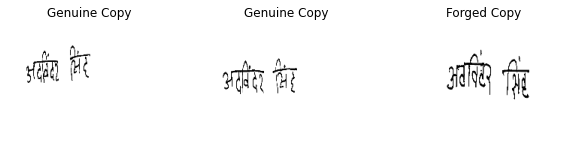

In [16]:
visualize_sample_signature()

In [17]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [18]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [19]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [20]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    Source: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    
    Explanation:
    When ytrue is 1, that means the sample are duplicates of each other, 
    so the Euclidean distance (ypred) between their outputs must be minimized.
    So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).
    When ytrue is 0, i.e. the samples are not duplicates, then the Euclidean distance 
    between them must be maximized, at least to the margin. So the loss to be minimized
    is the difference of the margin and the Euclidean distance - (margin - y_pred).
    If the Euclidean distance (ypred) is already greater than the margin, 
    then nothing is to be learned, so the loss is made to be zero in 
    that case by saying K.maximum(margin - y_pred, 0).
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [21]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, activation='relu'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, activation='relu')) # softmax changed to relu
    
    return seq

In [22]:
input_shape=(img_h, img_w, 1)

In [23]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model1 = Model(inputs=[input_a, input_b], outputs=distance)

In [24]:
batch_sz = 128
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [25]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
             EarlyStopping(monitor='val_loss',min_delta=0.001,patience=5,mode='min',verbose=1),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5, mode='auto',min_lr=0.000001, verbose=1),
             ModelCheckpoint('./signet-bhsig260-model1.h5', 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min',
                             monitor='val_loss',
                             min_delta=0.001,
                             patience=5,
                             verbose=1)
             ]            

In [26]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
#model1.compile(loss=contrastive_loss, optimizer=rms, metrics=['accuracy'])
model1.compile(loss=contrastive_loss, optimizer=rms)

In [27]:
results = model1.fit(generate_batch(orig_train, forg_train, batch_sz),
                    steps_per_epoch = num_train_samples//batch_sz,
                    epochs = 20,
                    validation_data = generate_batch(orig_val, forg_val, batch_sz),
                    validation_steps = num_val_samples//batch_sz,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/20
540/540 [==============================] - 275s 446ms/step - loss: 12.7795 - val_loss: 0.3066

Epoch 00001: val_loss improved from inf to 0.30656, saving model to ./signet-bhsig260-model1.h5
Epoch 2/20
540/540 [==============================] - 216s 400ms/step - loss: 0.1571 - val_loss: 0.3193

Epoch 00002: val_loss did not improve from 0.30656
Epoch 3/20
540/540 [==============================] - 214s 397ms/step - loss: 0.0822 - val_loss: 0.2324

Epoch 00003: val_loss improved from 0.30656 to 0.23236, saving model to ./signet-bhsig260-model1.h5
Epoch 4/20
540/540 [==============================] - 216s 401ms/step - loss: 0.0466 - val_loss: 0.1926

Epoch 00004: val_loss improved from 0.23236 to 0.19257, saving model to ./signet-bhsig260-model1.h5
Epoch 5/20
540/540 [==============================] - 214s 397ms/step - loss: 0.0265 - val_loss: 0.1705

Epoch 00005: val_loss improved from 0.19257 to 0.17055, saving model to ./signet-bhsig260-model1.h5
Epoch 6/20
540/540 [=======

In [28]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
        #print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [29]:
model1.load_weights('./signet-bhsig260-model1.h5')

In [30]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model1.predict([img1, img2])[0][0])

In [31]:
tr_acc1, threshold1 = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc1, threshold1	

(0.7072637275823306, 0.54)

In [32]:
batch_sz = 32
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [33]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model2 = Model(inputs=[input_a, input_b], outputs=distance)

In [34]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model2.compile(loss=contrastive_loss, optimizer=rms)

In [35]:
callbacks = [
             EarlyStopping(monitor='val_loss',min_delta=0.001,patience=5,mode='min',verbose=1),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5, mode='auto',min_lr=0.000001, verbose=1),
             #ModelCheckpoint('./signet-bhsig260-model2-{epoch:03d}.h5', 
             ModelCheckpoint('./signet-bhsig260-model2.h5', 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min',
                             monitor='val_loss',
                             min_delta=0.001,
                             patience=5,
                             verbose=1)
             ]  

In [36]:
results = model2.fit(generate_batch(orig_train, forg_train, batch_sz),
                    steps_per_epoch = num_train_samples//batch_sz,
                    epochs = 20,
                    validation_data = generate_batch(orig_val, forg_val, batch_sz),
                    validation_steps = num_val_samples//batch_sz,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/20
2160/2160 [==============================] - 236s 108ms/step - loss: 5.0338 - val_loss: 0.2422

Epoch 00001: val_loss improved from inf to 0.24218, saving model to ./signet-bhsig260-model2.h5
Epoch 2/20
2160/2160 [==============================] - 229s 106ms/step - loss: 0.0961 - val_loss: 0.2821

Epoch 00002: val_loss did not improve from 0.24218
Epoch 3/20
2160/2160 [==============================] - 227s 105ms/step - loss: 0.0382 - val_loss: 0.2574

Epoch 00003: val_loss did not improve from 0.24218
Epoch 4/20
2160/2160 [==============================] - 227s 105ms/step - loss: 0.0216 - val_loss: 0.4837

Epoch 00004: val_loss did not improve from 0.24218
Epoch 5/20
2160/2160 [==============================] - 227s 105ms/step - loss: 0.0137 - val_loss: 0.2107

Epoch 00005: val_loss improved from 0.24218 to 0.21070, saving model to ./signet-bhsig260-model2.h5
Epoch 6/20
2160/2160 [==============================] - 232s 107ms/step - loss: 0.0090 - val_loss: 0.3075

Epoch 000

In [37]:
model2.load_weights('./signet-bhsig260-model2.h5')

In [38]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model2.predict([img1, img2])[0][0])

In [39]:
tr_acc2, threshold2 = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc2, threshold2

(0.761168723969621, 0.51)

In [40]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return seq

In [41]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model3 = Model(inputs=[input_a, input_b], outputs=distance)

In [42]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model3.compile(loss=contrastive_loss, optimizer=rms)

In [43]:
callbacks = [
             EarlyStopping(monitor='val_loss',min_delta=0.001,patience=5,mode='min',verbose=1),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5, mode='auto',min_lr=0.000001, verbose=1),
             ModelCheckpoint('./signet-bhsig260-model3.h5', 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min',
                             monitor='val_loss',
                             min_delta=0.001,
                             patience=5,
                             verbose=1)
             ] 

In [44]:
results = model3.fit(generate_batch(orig_train, forg_train, batch_sz),
                    steps_per_epoch = num_train_samples//batch_sz,
                    epochs = 20,
                    validation_data = generate_batch(orig_val, forg_val, batch_sz),
                    validation_steps = num_val_samples//batch_sz,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/20
2160/2160 [==============================] - 259s 120ms/step - loss: 1.4222 - val_loss: 0.1433

Epoch 00001: val_loss improved from inf to 0.14325, saving model to ./signet-bhsig260-model3.h5
Epoch 2/20
2160/2160 [==============================] - 231s 107ms/step - loss: 0.0936 - val_loss: 0.1610

Epoch 00002: val_loss did not improve from 0.14325
Epoch 3/20
2160/2160 [==============================] - 231s 107ms/step - loss: 0.0422 - val_loss: 0.1312

Epoch 00003: val_loss improved from 0.14325 to 0.13117, saving model to ./signet-bhsig260-model3.h5
Epoch 4/20
2160/2160 [==============================] - 231s 107ms/step - loss: 0.0238 - val_loss: 0.1654

Epoch 00004: val_loss did not improve from 0.13117
Epoch 5/20
2160/2160 [==============================] - 233s 108ms/step - loss: 0.0154 - val_loss: 0.2187

Epoch 00005: val_loss did not improve from 0.13117
Epoch 6/20
2160/2160 [==============================] - 232s 107ms/step - loss: 0.0102 - val_loss: 0.1697

Epoch 000

In [45]:
model3.load_weights('./signet-bhsig260-model3.h5')

In [46]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model3.predict([img1, img2])[0][0])

In [47]:
tr_acc3, threshold3 = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc3, threshold3

(0.8271529888551166, 0.4400147200134961)

#### Accuracy = 82.7% and Threshold = 0.44
Thus if the differnce score is less than 0.44, we predict the test image as Genuine and if the difference score is greater than 0.44, we predict it to be as forged

#### Below we see some sample results

In [61]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    if (tr_acc3 > tr_acc2) and (tr_acc3 > tr_acc1):
      result = model3.predict([img1, img2])
      threshold=threshold3
    elif (tr_acc2 > tr_acc3) and (tr_acc2 > tr_acc1):
      result = model2.predict([img1, img2])
      threshold=threshold2
    elif (tr_acc1 > tr_acc3) and (tr_acc1 > tr_acc2):
        result = model1.predict([img1, img2])
        threshold=threshold1

    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

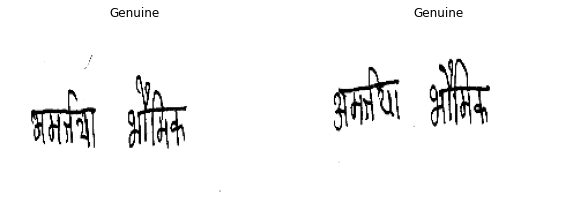

Difference Score =  0.026991459
Its a Genuine Signature


In [62]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

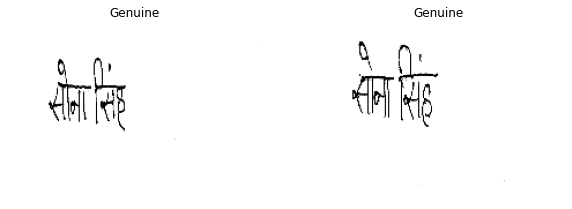

Difference Score =  0.04670689
Its a Genuine Signature


In [63]:
predict_score()

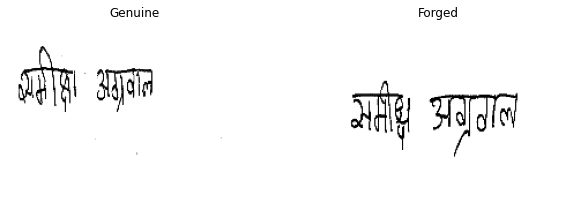

Difference Score =  1.3316591
Its a Forged Signature


In [64]:
predict_score()

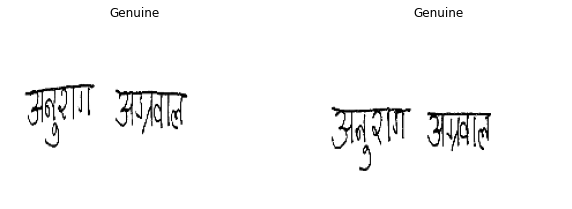

Difference Score =  0.12422163
Its a Genuine Signature


In [65]:
predict_score()